# Regresión con RNAs Multicapa

In [109]:
#install.packages("tidyverse")
#install.packages("gganimate")
#install.packages("plotly")
#install.packages("gifski")
#install.packages("RColorBrewer")
#install.packages("wesanderson")
#install.packages("neuralnet")
#install.packages("NeuralNetTools")

library(gifski)
library(tidyverse)
library(gganimate)
library(plotly)
library(RColorBrewer)
library(wesanderson)


library(neuralnet)
library(NeuralNetTools)
library(ggplot2)

library(gifski)
library(tidyverse)
library(gganimate)
library(plotly)
library(RColorBrewer)
library(wesanderson)

In [2]:
# código limpieza y manipulación 
casos_diarios <-  read.csv(file = "Casos_Diarios_Estado_Nacional.csv")
casos_diario_list <- gather(casos_diarios,key ="dias",value="infectados",4:856)

normalizarfecha <- function(fecha){
return(str_replace_all(fecha,"X","")  %>% str_replace_all("\\.","/"))
}

cod_Meses <- function(x) {

labels_meses <- c(
    "Ene","Feb","Mar","Abr","May","Jun",
    "Jul","Ago","Sep","Oct","Nov","Dic")

    return(factor(x,levels = (1:12),labels = labels_meses))
    
    }

fecha = map(casos_diario_list[4],normalizarfecha)
casos_diarios_fecha <- cbind(casos_diario_list[c(TRUE,TRUE,TRUE,FALSE,TRUE)],fecha)
casos_diarios_fecha <- casos_diarios_fecha[c(1,2,3,5,4)]

datos <- separate( data = casos_diarios_fecha,
                   col =dias,
                   into = c("dia","mes","año"),
                   sep = '/',
                   remove = FALSE)
#recordatorio
datos <- datos %>% mutate(mest_txt = cod_Meses(as.integer(mes))) %>% mutate(consecutivo = 1:28149)
str(datos)

head(datos)



'data.frame':	28149 obs. of  10 variables:
 $ cve_ent    : int  1 2 3 4 7 8 9 5 6 10 ...
 $ poblacion  : int  1434635 3634868 804708 1000617 5730367 3801487 9018645 3218720 785153 1868996 ...
 $ nombre     : chr  "AGUASCALIENTES" "BAJA CALIFORNIA" "BAJA CALIFORNIA SUR" "CAMPECHE" ...
 $ dias       : chr  "26/02/2020" "26/02/2020" "26/02/2020" "26/02/2020" ...
 $ dia        : chr  "26" "26" "26" "26" ...
 $ mes        : chr  "02" "02" "02" "02" ...
 $ año        : chr  "2020" "2020" "2020" "2020" ...
 $ infectados : int  0 0 0 0 0 0 0 0 0 0 ...
 $ mest_txt   : Factor w/ 12 levels "Ene","Feb","Mar",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ consecutivo: int  1 2 3 4 5 6 7 8 9 10 ...


,cve_ent,poblacion,nombre,dias,dia,mes,año,infectados,mest_txt,consecutivo
,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<fct>,<int>
1,1,1434635,AGUASCALIENTES,26/02/2020,26,02,2020,0,Feb,1
2,2,3634868,BAJA CALIFORNIA,26/02/2020,26,02,2020,0,Feb,2
3,3,804708,BAJA CALIFORNIA SUR,26/02/2020,26,02,2020,0,Feb,3
4,4,1000617,CAMPECHE,26/02/2020,26,02,2020,0,Feb,4
5,7,5730367,CHIAPAS,26/02/2020,26,02,2020,0,Feb,5
6,8,3801487,CHIHUAHUA,26/02/2020,26,02,2020,0,Feb,6


## Tratamiento adicional de los datos

In [3]:
# Tratamiento de datos
##
datosf <- datos %>% filter(año == "2020") %>% filter(nombre == "Nacional")  %>% mutate(consecutivo = 1:310)  %>%
        mutate(infectadosnew = ((infectados/poblacion)*100000))

#head(datosf)
#str(datosf)

#obtener variables parta normalizar datos
min_d <- datosf  %>% select(consecutivo, poblacion, infectadosnew) %>% apply(2, min)
max_d <- datosf  %>% select(consecutivo, poblacion, infectadosnew) %>% apply(2, max)
min_d[2] <- 0
#min_d
#max_d

min_inf <- min(datosf$infectadosnew)
max_inf <- max(datosf$infectadosnew)

#normalizacion de datos
dnacionalnorm <- scale(select(datosf, consecutivo, poblacion, infectadosnew), center = min_d, scale = max_d - min_d)
head(dnacionalnorm)

consecutivo,poblacion,infectadosnew
0.000000000,1,0.0000000000
0.003236246,1,0.0002465483
0.006472492,1,0.0001232742
0.009708738,1,0.0001232742
0.012944984,1,0.0001232742
0.016181230,1,0.0003081854


## Modelo Machine Learning

In [4]:
f <- as.formula(infectadosnew ~ consecutivo)
f

infectadosnew ~ consecutivo

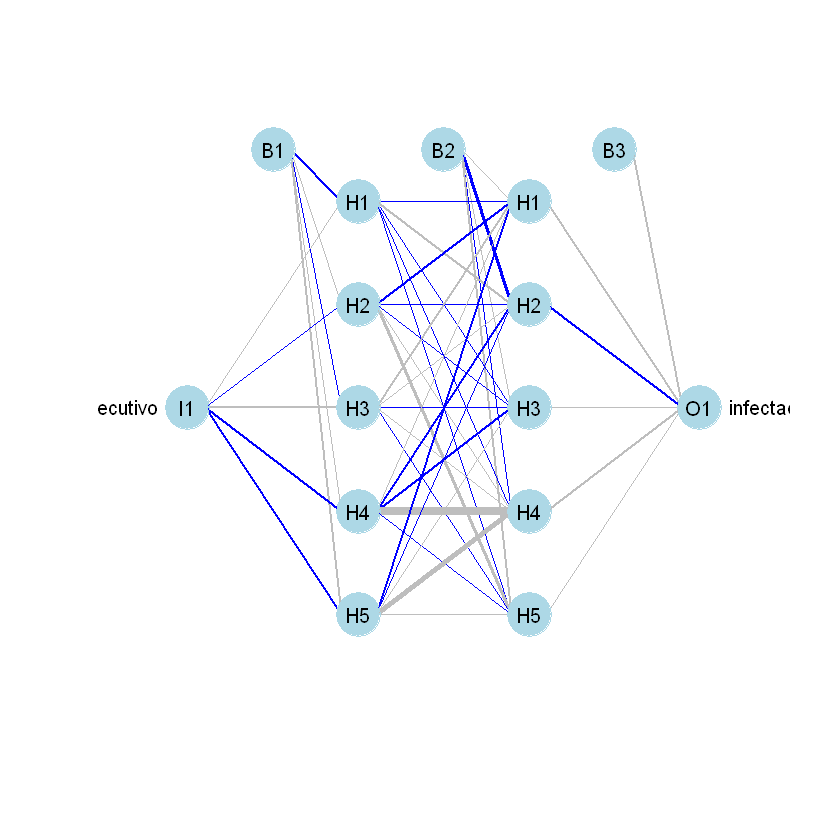

In [37]:
nnet <- neuralnet(f, data = dnacionalnorm,
                  hidden = c(5,5),
                  threshold = 0.05,
                  algorithm = "rprop+",
                  stepmax = 10000,
                  #rep = 5,
                  act.fct = "tanh") 
##
plotnet(nnet, 
        circle_col = "lightblue",
        pos_col = "blue",
        neg_col = "grey",
        bord_col = "lightblue",)

# Visualización de datos

In [7]:
eval_nn <- predict(nnet, dnacionalnorm[, 1:2])
eval_nn
str(eval_nn)

-0.0154157194
-0.0144311607
-0.0134348087
-0.0124258482
-0.0114035074
-0.0103670531
-0.0093157865
-0.0082490383
-0.0071661642
-0.0060665397
-0.0049495557


 num [1:310, 1] -0.0154 -0.0144 -0.0134 -0.0124 -0.0114 ...


## Predecir entidades

[1] "nombre"      "consecutivo" "infectados"

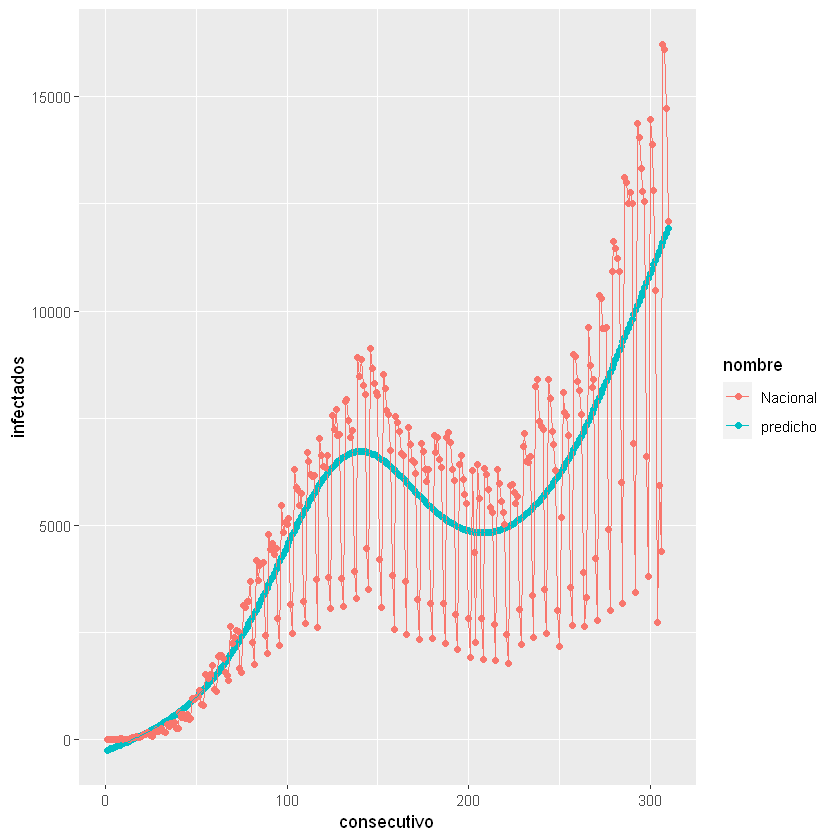

In [8]:
# Graficar los datos recuperadops

resultado <- data.frame(
                        nombre = "predicho",
                        consecutivo = 1:310,
                        infectados = eval_nn * ((max_inf - min_inf)+min_inf)*max_d[2]/100000)


datosfs <- datosf %>% select(nombre, consecutivo, infectados)
resultado <- rbind(resultado, datosfs)
#resultado
names(resultado)

resultado %>% ggplot(aes(x = consecutivo, y = infectados, group = nombre, color = nombre)) +
geom_point( ) + geom_line()




poblacion 
"9018645"

[1] "nombre"      "consecutivo" "infectados"

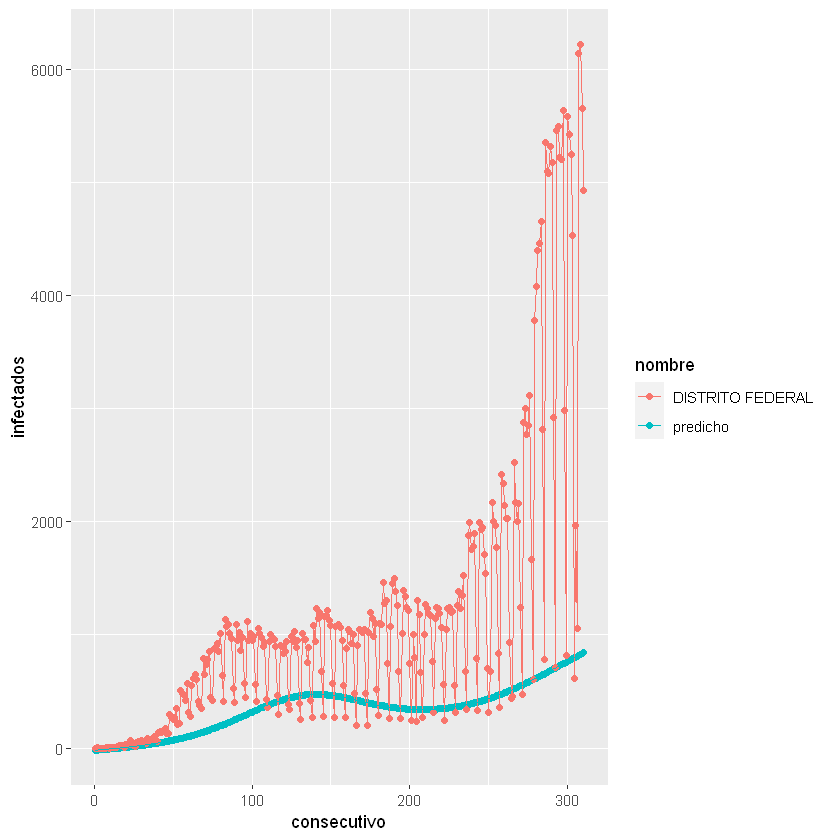

In [9]:
datosdf <- datos %>% filter(año == "2020") %>% filter(nombre == "DISTRITO FEDERAL")  %>% mutate(consecutivo = 1:310)  %>%
        mutate(infectadosnew = ((infectados/poblacion)*100000))

ddfnorm <- scale(select(datosdf, consecutivo, poblacion, infectadosnew), center = min_d, scale = max_d - min_d)
#head(ddfnorm)

#Prediccion
eval_nn <- predict(nnet, ddfnorm[, 1:2])

max_df <- apply(datosdf, 2, max)
max_df[2]
###
# Graficar los datos recuperadops

resultado <- data.frame(
                        nombre = "predicho",
                        consecutivo = 1:310,
                        infectados = eval_nn * ((max_inf - min_inf)+min_inf)*as.integer(max_df[2])/100000)


datosfs <- datosdf %>% select(nombre, consecutivo, infectados)
resultado <- rbind(resultado, datosfs)
#resultado
names(resultado)

resultado %>% ggplot(aes(x = consecutivo, y = infectados, group = nombre, color = nombre)) +
    geom_point( ) + 
    geom_line()


poblacion 
"17427790"

[1] "nombre"      "consecutivo" "infectados"

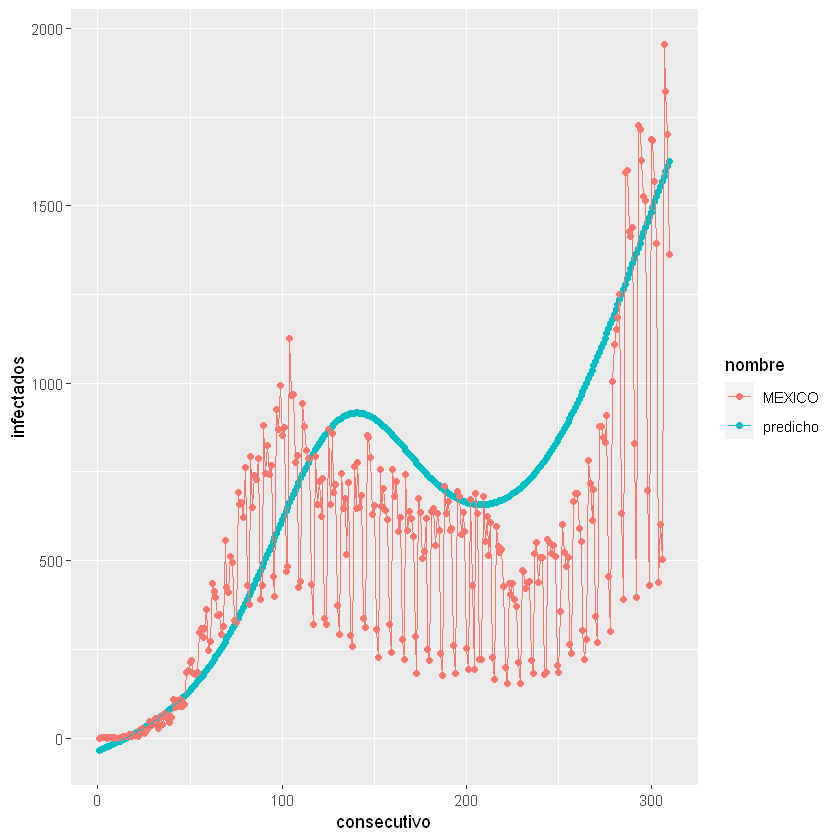

In [10]:
datosdf <- datos %>% filter(año == "2020") %>% filter(nombre == "MEXICO")  %>% mutate(consecutivo = 1:310)  %>%
        mutate(infectadosnew = ((infectados/poblacion)*100000))

ddfnorm <- scale(select(datosdf, consecutivo, poblacion, infectadosnew), center = min_d, scale = max_d - min_d)
#head(ddfnorm)

#Prediccion
eval_nn <- predict(nnet, ddfnorm[, 1:2])

max_df <- apply(datosdf, 2, max)
max_df[2]
###
# Graficar los datos recuperadops

resultado <- data.frame(
                        nombre = "predicho",
                        consecutivo = 1:310,
                        infectados = eval_nn * ((max_inf - min_inf)+min_inf)*as.integer(max_df[2])/100000)


datosfs <- datosdf %>% select(nombre, consecutivo, infectados)
resultado <- rbind(resultado, datosfs)
#resultado
names(resultado)

resultado %>% ggplot(aes(x = consecutivo, y = infectados, group = nombre, color = nombre)) +
    geom_point( ) + 
    geom_line()


# Predecir el siguiente 10% de datos 


[1] 1474.562

[1] 5142.72

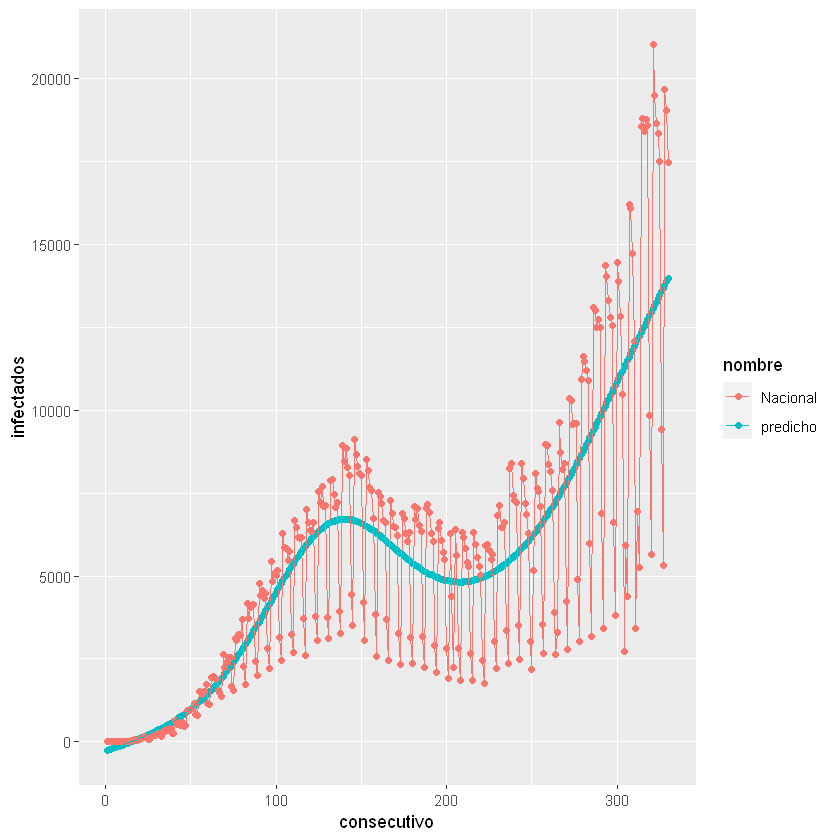

In [32]:
# Tratamiento de datos
datosf <- datos %>% filter(nombre == "Nacional") %>%  mutate(consecutivo = 1:853)  %>%
        mutate(infectadosnew = ((infectados/poblacion)*100000)) %>% filter(consecutivo <= 330)

dnacionalnorm <- scale(select(datosf, consecutivo, poblacion, infectadosnew), center = min_d, scale = max_d - min_d)

#Prediccion
eval_nn <- predict(nnet, dnacionalnorm[, 1:2])

# Graficar los datos recuperadops

resultado <- data.frame(
                        nombre = "predicho",
                        consecutivo = 1:330,
                        infectados = eval_nn * ((max_inf - min_inf)+min_inf)*max_d[2]/100000)


datosfs <- datosf %>% select(nombre, consecutivo, infectados)
resultado <- rbind(resultado, datosfs)
#resultado
#names(resultado)

resultado %>% ggplot(aes(x = consecutivo, y = infectados, group = nombre, color = nombre)) +
geom_point( ) + geom_line() #+ geom_cartesian(xlim = c(300, 330))

mean(abs(resultado$infectados[1:310] - datosfs$infectados[1:310]))
mean(abs(resultado$infectados[300:330] - datosfs$infectados[300:330]))

# Ejercicio 1

Replique el ejemplo de la predicción de los siguientes 30 días de su municipio y de otros dos y anime la gráfica con gganimate. 
</br>
* Comparta por el chat o el github su GIF</br>
* Comparta la estructura de su modelo de la RNA</br>
* Calcule su error de sesgo y la varianza 



In [54]:
casos_diarios_municipio <-  read.csv(file = "Casos_Diarios_Municipio.csv")
casos_diarios_duango <- casos_diarios_municipio[casos_diarios_municipio$cve_ent == c("10005", "10012", "10004"), ]
casos_diarios_duango

,cve_ent,poblacion,nombre,X26.02.2020,X27.02.2020,X28.02.2020,X29.02.2020,X01.03.2020,X02.03.2020,X03.03.2020,...,X18.06.2022,X19.06.2022,X20.06.2022,X21.06.2022,X22.06.2022,X23.06.2022,X24.06.2022,X25.06.2022,X26.06.2022,X27.06.2022
,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
702,10004,37479,Cuencame,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
703,10005,695597,Durango,0,0,0,0,0,0,0,...,14,18,119,93,120,130,96,22,21,0
713,10012,164763,Lerdo,0,0,0,0,0,0,0,...,0,0,7,1,3,0,7,0,0,0


In [61]:
# código limpieza y manipulación 
casos_diario_list <- gather(casos_diarios_duango,key ="dias",value="infectados",4:856)

normalizarfecha <- function(fecha){
return(str_replace_all(fecha,"X","")  %>% str_replace_all("\\.","/"))
}

cod_Meses <- function(x) {

labels_meses <- c(
    "Ene","Feb","Mar","Abr","May","Jun",
    "Jul","Ago","Sep","Oct","Nov","Dic")

    return(factor(x,levels = (1:12),labels = labels_meses))
    
    }

fecha = map(casos_diario_list[4],normalizarfecha)
casos_diarios_fecha <- cbind(casos_diario_list[c(TRUE,TRUE,TRUE,FALSE,TRUE)],fecha)
casos_diarios_fecha <- casos_diarios_fecha[c(1,2,3,5,4)]

datos <- separate( data = casos_diarios_fecha,
                   col =dias,
                   into = c("dia","mes","año"),
                   sep = '/',
                   remove = FALSE)
datos

#recordatorio
datos <- datos %>% mutate(mest_txt = cod_Meses(as.integer(mes))) %>% mutate(consecutivo = 1:2559)
str(datos)

head(datos)


cve_ent,poblacion,nombre,dias,dia,mes,año,infectados
<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
10004,37479,Cuencame,26/02/2020,26,02,2020,0
10005,695597,Durango,26/02/2020,26,02,2020,0
10012,164763,Lerdo,26/02/2020,26,02,2020,0
10004,37479,Cuencame,27/02/2020,27,02,2020,0
10005,695597,Durango,27/02/2020,27,02,2020,0
10012,164763,Lerdo,27/02/2020,27,02,2020,0
10004,37479,Cuencame,28/02/2020,28,02,2020,0
10005,695597,Durango,28/02/2020,28,02,2020,0
10012,164763,Lerdo,28/02/2020,28,02,2020,0


'data.frame':	2559 obs. of  10 variables:
 $ cve_ent    : int  10004 10005 10012 10004 10005 10012 10004 10005 10012 10004 ...
 $ poblacion  : int  37479 695597 164763 37479 695597 164763 37479 695597 164763 37479 ...
 $ nombre     : chr  "Cuencame" "Durango" "Lerdo" "Cuencame" ...
 $ dias       : chr  "26/02/2020" "26/02/2020" "26/02/2020" "27/02/2020" ...
 $ dia        : chr  "26" "26" "26" "27" ...
 $ mes        : chr  "02" "02" "02" "02" ...
 $ año        : chr  "2020" "2020" "2020" "2020" ...
 $ infectados : int  0 0 0 0 0 0 0 0 0 0 ...
 $ mest_txt   : Factor w/ 12 levels "Ene","Feb","Mar",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ consecutivo: int  1 2 3 4 5 6 7 8 9 10 ...


,cve_ent,poblacion,nombre,dias,dia,mes,año,infectados,mest_txt,consecutivo
,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<fct>,<int>
1,10004,37479,Cuencame,26/02/2020,26,02,2020,0,Feb,1
2,10005,695597,Durango,26/02/2020,26,02,2020,0,Feb,2
3,10012,164763,Lerdo,26/02/2020,26,02,2020,0,Feb,3
4,10004,37479,Cuencame,27/02/2020,27,02,2020,0,Feb,4
5,10005,695597,Durango,27/02/2020,27,02,2020,0,Feb,5
6,10012,164763,Lerdo,27/02/2020,27,02,2020,0,Feb,6


In [ ]:
## Modelo Machine Learning municipios

In [70]:
# Tratamiento de datos
##
datosf <- datos %>% filter(año == "2020") %>%  mutate(consecutivo = 1:930)  %>%
        mutate(infectadosnew = ((infectados/poblacion)*100000))

#head(datosf)
#str(datosf)

#obtener variables parta normalizar datos
min_d <- datosf  %>% select(consecutivo, poblacion, infectadosnew) %>% apply(2, min)
max_d <- datosf  %>% select(consecutivo, poblacion, infectadosnew) %>% apply(2, max)
min_d[2] <- 0
#min_d
#max_d

min_inf <- min(datosf$infectadosnew)
max_inf <- max(datosf$infectadosnew)

#normalizacion de datos
dnacionalnorm <- scale(select(datosf, consecutivo, poblacion, infectadosnew), center = min_d, scale = max_d - min_d)
head(dnacionalnorm)

consecutivo,poblacion,infectadosnew
0.000000000,0.05388034,0
0.001076426,1.00000000,0
0.002152853,0.23686560,0
0.003229279,0.05388034,0
0.004305705,1.00000000,0
0.005382131,0.23686560,0


In [76]:
f <- as.formula(infectadosnew ~ consecutivo)
f

infectadosnew ~ consecutivo

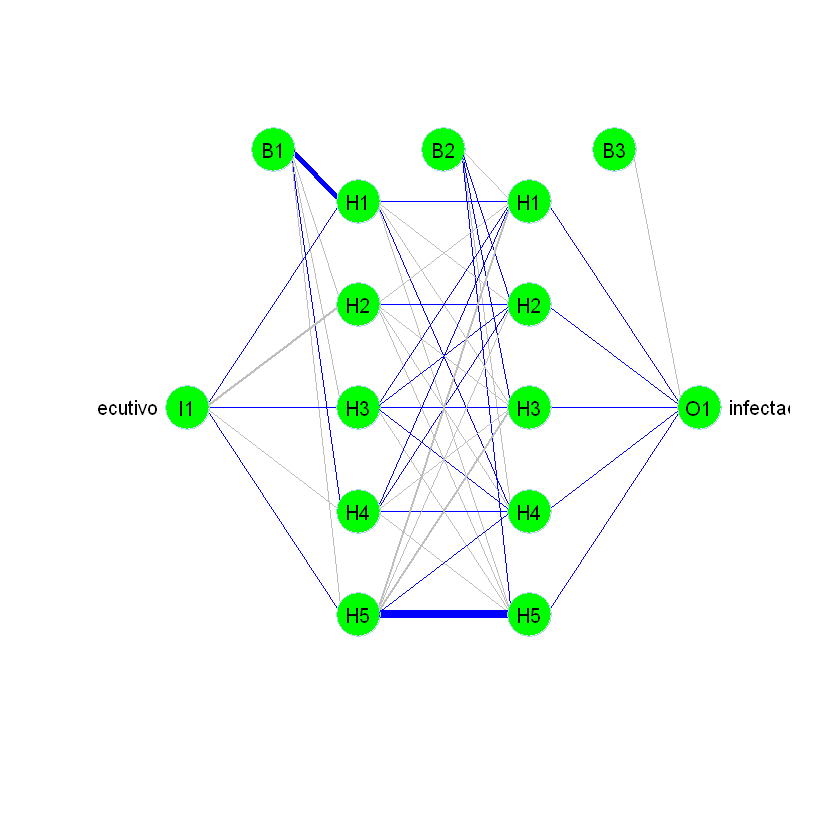

In [78]:
nnet <- neuralnet(f, data = dnacionalnorm,
                  hidden = c(5,5),
                  threshold = 0.05,
                  algorithm = "rprop+",
                  stepmax = 10000,
                  #rep = 5,
                  act.fct = "tanh") 
##
plotnet(nnet, 
        circle_col = "green",
        pos_col = "blue",
        neg_col = "grey",
        bord_col = "lightblue",)

In [85]:
length(datosf$poblacion)

[1] 930

[1] 3.784323

[1] 12.47061

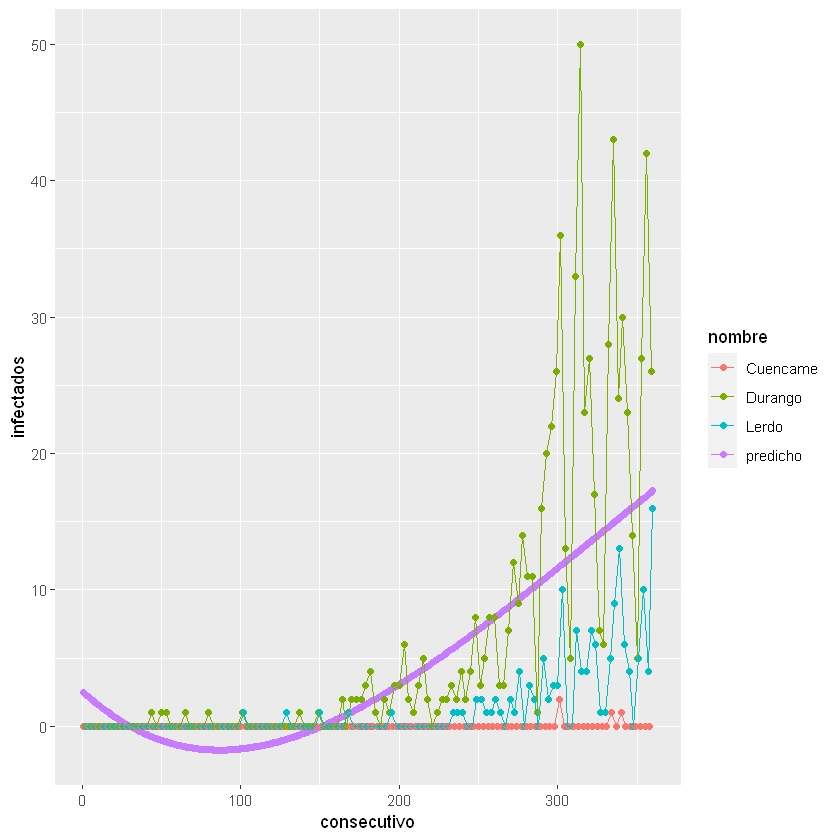

In [91]:
# Tratamiento de datos
datosf <- datosf  %>% mutate(consecutivo = 1:360)  %>%
        mutate(infectadosnew = ((infectados/poblacion)*100000)) %>% filter(consecutivo <= 360)

dnacionalnorm <- scale(select(datosf, consecutivo, poblacion, infectadosnew), center = min_d, scale = max_d - min_d)

#Prediccion
eval_nn <- predict(nnet, dnacionalnorm[, 1:2])

# Graficar los datos recuperadops

resultado <- data.frame(
                        nombre = "predicho",
                        consecutivo = 1:360,
                        infectados = eval_nn * ((max_inf - min_inf)+min_inf)*max_d[2]/100000)


datosfs <- datosf %>% select(nombre, consecutivo, infectados)
resultado <- rbind(resultado, datosfs)
#resultado
#names(resultado)

resultado %>% ggplot(aes(x = consecutivo, y = infectados, group = nombre, color = nombre)) +
geom_point( ) + geom_line() #+ geom_cartesian(xlim = c(300, 330))

mean(abs(resultado$infectados[1:340] - datosfs$infectados[1:340]))
mean(abs(resultado$infectados[340:360] - datosfs$infectados[340:360]))

In [95]:
names(datosf)


[1] "cve_ent"       "poblacion"     "nombre"        "dias"         
 [5] "dia"           "mes"           "año"           "infectados"   
 [9] "mest_txt"      "consecutivo"   "infectadosnew"

In [110]:
options(jupyter.plot_mimetypes = 'image/png')

p1  <-    resultado %>%
    ggplot(aes(x = consecutivo, y = infectados, group = nombre, color = nombre)) +
    geom_point( ) + geom_line() #+ geom_cartesian(xlim = c(300, 330))
       # stat_smooth(method ="gam",aes(x = dias, y = infectados)) #+
       # coord_cartesian(xlim = c (as.Date("01/12/2020","%d/%m/%Y"),as.Date("01/02/2021","%d/%m/%Y")))+
        transition_reveal(dias)


mi_gif <- animate(p1,width = 1600,height = 800,render = gifski_renderer(loop = TRUE))
anim_save(filename= "animacion.gif")


<ggproto object: Class TransitionReveal, Transition, gg>
    adjust_nframes: function
    expand_data: function
    expand_layer: function
    expand_panel: function
    finish_data: function
    get_all_row_vars: function
    get_frame_data: function
    get_frame_vars: function
    get_row_vars: function
    map_data: function
    mapping: (.+)
    params: list
    remap_frames: function
    require_late_tween: function
    setup_params: function
    setup_params2: function
    static_layers: function
    unmap_frames: function
    var_names: along
    super:  <ggproto object: Class TransitionReveal, Transition, gg>

ERROR: Error in animate.default(p1, width = 1600, height = 800, render = gifski_renderer(loop = TRUE)): animation of gg objects not supported
